In [1]:
#Load libraries
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib

In [9]:
os.listdir()

['.android',
 '.bash_history',
 '.conda',
 '.config',
 '.emulator_console_auth_token',
 '.fx',
 '.gradle',
 '.ipynb_checkpoints',
 '.ipython',
 '.jupyter',
 '.matplotlib',
 '.vscode',
 '3D Objects',
 'anaconda3',
 'ansel',
 'AppData',
 'Application Data',
 'Contacts',
 'Cookies',
 'Documents',
 'Downloads',
 'Favorites',
 'Intel',
 'IntelGraphicsProfiles',
 'Links',
 'Local Settings',
 'Music',
 'My Documents',
 'NetHood',
 'NTUSER.DAT',
 'ntuser.dat.LOG1',
 'ntuser.dat.LOG2',
 'NTUSER.DAT{368696da-871a-11ec-9908-ad737a7e6322}.TM.blf',
 'NTUSER.DAT{368696da-871a-11ec-9908-ad737a7e6322}.TMContainer00000000000000000001.regtrans-ms',
 'NTUSER.DAT{368696da-871a-11ec-9908-ad737a7e6322}.TMContainer00000000000000000002.regtrans-ms',
 'ntuser.ini',
 'OneDrive',
 'OneDrive - iitkgp.ac.in',
 'PrintHood',
 'Recent',
 'Saved Games',
 'Searches',
 'SendTo',
 'Start Menu',
 'Templates',
 'Untitled.ipynb',
 'Videos']

In [3]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
print(device)


cuda


In [5]:
#Transforms
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [13]:
path='/Downloads/archive/scene_detection/seg_test/seg_test'


In [19]:
#Dataloader

#Path for training and testing directory
train_path='/Users/Kartheek/Downloads/archive/seg_train/seg_train'
test_path='/Users/Kartheek/Downloads/archive/seg_train/seg_train'

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=64, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=32, shuffle=True
)

In [20]:
#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [21]:
#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [22]:
print(classes)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [23]:
#CNN Network


class ConvNet(nn.Module):
    def __init__(self,num_classes=6):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #((w-f+2P)/s) +1
        
        #Input shape= (256,3,150,150)
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.ReLU()
        #Shape= (256,12,150,150)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)
        
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu2=nn.ReLU()
        #Shape= (256,20,75,75)
        
        
        
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,75,75)
        self.relu3=nn.ReLU()
        #Shape= (256,32,75,75)
        
        
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)
        
        
        
        #Feed forwad function
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
            
            
            #Above output will be in matrix form, with shape (256,32,75,75)
            
        output=output.view(-1,32*75*75)
            
            
        output=self.fc(output)
            
        return output


In [24]:
model=ConvNet(num_classes=6).to(device)

In [25]:
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [26]:
num_epochs=10

In [27]:
#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))

In [28]:
print(train_count,test_count)

14034 14034


In [29]:
#Model training and saving best model

best_accuracy=0.0

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy


Epoch: 0 Train Loss: tensor(6.2039) Train Accuracy: 0.5850078381074534 Test Accuracy: 0.7588000570044179
Epoch: 1 Train Loss: tensor(2.0263) Train Accuracy: 0.7228160182414137 Test Accuracy: 0.8038335470999003
Epoch: 2 Train Loss: tensor(1.2221) Train Accuracy: 0.7991306826279037 Test Accuracy: 0.8666096622488243
Epoch: 3 Train Loss: tensor(1.1197) Train Accuracy: 0.814236853356135 Test Accuracy: 0.7860196665241557
Epoch: 4 Train Loss: tensor(0.6323) Train Accuracy: 0.8760153911928175 Test Accuracy: 0.9335898532136241
Epoch: 5 Train Loss: tensor(0.4062) Train Accuracy: 0.9049451332478267 Test Accuracy: 0.9219752030782385
Epoch: 6 Train Loss: tensor(0.2327) Train Accuracy: 0.9362263075388343 Test Accuracy: 0.9030924896679493
Epoch: 7 Train Loss: tensor(0.1807) Train Accuracy: 0.9496223457317942 Test Accuracy: 0.9530426108023372
Epoch: 8 Train Loss: tensor(0.1515) Train Accuracy: 0.9596693743765142 Test Accuracy: 0.9697876585435371
Epoch: 9 Train Loss: tensor(0.1470) Train Accuracy: 0.96

/Users/Kartheek/Downloads/archive/seg_train/seg_train\buildings\0.jpg


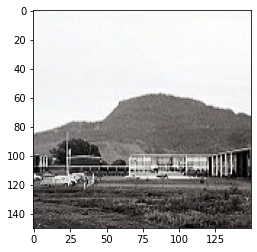

In [35]:
import matplotlib.pyplot as plt

testImg = plt.imread(glob.glob(test_path+'/**/*.jpg')[0])
print(glob.glob(test_path+'/**/*.jpg')[0])
plt.imshow(testImg)

In [40]:
temp = next(iter(test_loader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 150, 150])
<class 'numpy.ndarray'>
(150, 150, 3)
tensor([3, 0, 3, 4, 0, 1, 5, 2, 5, 5, 3, 5, 3, 2, 1, 4, 5, 4, 4, 3, 1, 0, 4, 2,
        2, 4, 0, 0, 3, 4, 1, 4])


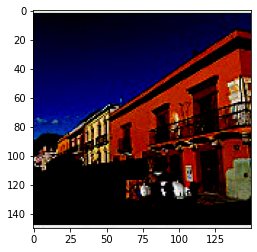

In [63]:
print(temp[0].shape)
tempImg = np.array(temp[0][6])
print(type(tempImg))
IMg = np.stack([tempImg[0,:,:],tempImg[1,:,:],tempImg[2,:,:]], axis=2)
print(IMg.shape)
plt.imshow(IMg)
print(temp[1])
'''
'buildings' -> 0,
'forest' -> 1,
'glacier' -> 2,
'mountain' -> 3,
'sea' -> 4,
'street' -> 5
'''

In [47]:
out = model(temp[0].to(device))

In [51]:
out.argmax(1)

tensor([4, 0, 3, 4, 0, 1, 5, 2, 5, 5, 3, 5, 3, 2, 1, 4, 5, 4, 4, 3, 1, 0, 4, 2,
        2, 4, 0, 0, 3, 4, 1, 4], device='cuda:0')